In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from torch import unsqueeze

!pip install torchattacks
import torchattacks


     |████████████████████████████████| 102 kB 3.9 MB/s 


In [4]:
## If Running in google colab
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
! ls /content/drive/MyDrive/Fair_Robust_Modeling/


fashion_mnist_model_training.ipynb  model_artifacts
FRL_Remargin_fashion_MNIST.ipynb    utility_functions.py
FRL_Reweight_fashion_MNIST.ipynb


In [6]:
dir_path = '/content/drive/MyDrive/Fair_Robust_Modeling/'

In [7]:
!cp /content/drive/MyDrive/Fair_Robust_Modeling/utility_functions.py .

In [11]:
from utility_functions import LeNet5, train_model, test_model, get_accs, show_both_losses_by_class, update_epislon, remargin_for_robust_fairness

In [9]:

# Image preprocessing modules
transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])

train_dataset = datasets.FashionMNIST(root = '.',
                              train = True,
                              download = True, 
                              transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

test_data = datasets.FashionMNIST(root = '.',
                             train = False, 
                             download = True, 
                             transform=transform)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



## Fair Robust Learning (FRL) Remargin Process

The following is the FRL Algorithm outlined in the paper:
1. Inputs: adv. model (f), fairness constraints t1>0, t2>0, attack radius e and hyperparam update weights a1, a2. Output: fair robust model
2. Load robust model
3. Initialize e_bnd = 0 (vector of epsilon bounds for training attack)
4. repeat:
5. R_bnd(f), R_bnd(f, i) = EVAL(f, e) (calculate boundary error [i.e. existence of adv. example that changes f's prediction] in total and by class)
8. e_bnd(i) = e_bnd(i) + a1(R_bnd(f, i)-R_bnd(f) - t2)
9. f <- TRAIN(f, phi, e) (using updated epsilons to make training on problem classes harder, and make model focus on them more)
10. Until f satisfies constraints

For details on the implementation of the training process and epsilon updating, see the utility functions "update_epsilon" and "remargin_for_robust_fairness."

Below we have a setup to run the process once with alpha values 1 and 10-- note that in general the second alpha value should be pretty big to get a reasonable epsilon resizing with the exponential update. 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

adv_model_state = torch.load(dir_path +'model_artifacts/adversarially_trained_model.pt')
adv_model = LeNet5(10)
adv_model.load_state_dict(adv_model_state)
adv_model = adv_model.to(device)
atk = torchattacks.PGD(adv_model, eps=16/255, alpha=1/255, steps=20, random_start=True)
num_epochs = 10
learning_rate = 0.0001


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(adv_model.parameters(), lr=learning_rate)

batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                         batch_size=batch_size, 
                                         shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_data,
                                         batch_size=batch_size, 
                                         shuffle=True)

phi = phi = torch.stack([torch.ones(10),torch.ones(10)]).cuda()
eps = torch.zeros(10).to(device) + 8/255
a1 = 1
a2 = 10
a3 = 1
a4 = 1
t1 = 0.05
t2 = 0.05

fair_model = remargin_for_robust_fairness(adv_model,
                                          atk,
                                          num_epochs, 
                                          learning_rate, 
                                          device, 
                                          criterion,
                                          optimizer, 
                                          train_loader,
                                          val_loader,
                                          phi,
                                          eps,
                                          a1, 
                                          a2,
                                          a3, 
                                          a4,
                                          t1,
                                          t2)

/content/utility_functions.py:503: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  nat_phi = sm(phi[0])


Epoch [1/10], Step [100/480] Loss: 3.2638
Epoch [1/10], Step [200/480] Loss: 3.0739
Epoch [1/10], Step [300/480] Loss: 2.9784
Epoch [1/10], Step [400/480] Loss: 3.0570
Epoch [2/10], Step [100/480] Loss: 2.8599
Epoch [2/10], Step [200/480] Loss: 2.7007
Epoch [2/10], Step [300/480] Loss: 2.8806
Epoch [2/10], Step [400/480] Loss: 2.8625
Epoch [3/10], Step [100/480] Loss: 2.7928
Epoch [3/10], Step [200/480] Loss: 2.7576
Epoch [3/10], Step [300/480] Loss: 2.8552
Epoch [3/10], Step [400/480] Loss: 2.7141
Epoch [4/10], Step [100/480] Loss: 2.8061
Epoch [4/10], Step [200/480] Loss: 2.7554
Epoch [4/10], Step [300/480] Loss: 2.7615
Epoch [4/10], Step [400/480] Loss: 2.7156
Epoch [5/10], Step [100/480] Loss: 2.7719
Epoch [5/10], Step [200/480] Loss: 2.7647
Epoch [5/10], Step [300/480] Loss: 2.7289
Epoch [5/10], Step [400/480] Loss: 2.7142
Epoch [6/10], Step [100/480] Loss: 2.8256
Epoch [6/10], Step [200/480] Loss: 2.7650
Epoch [6/10], Step [300/480] Loss: 2.6978
Epoch [6/10], Step [400/480] Loss:

In [ ]:
torch.save(fair_model.state_dict(), dir_path+'model_artifacts/FRL_RM_model_a1_{}_a2_{}.pt'.format(a1, a2))

In [ ]:
test_loader = test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=300, 
                                          shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

eps=16/255
alpha=2/255
steps=20

adv_model_pgd_loss = get_accs(fair_model, test_loader, criterion, device, eps, alpha, steps, adv=True)
adv_model_regular_loss = get_accs(fair_model, test_loader, criterion, device, eps, alpha, steps, adv=False)

Working on round 1
Working on round 2
Working on round 3
Working on round 4
Working on round 5
Working on round 6
Working on round 7
Working on round 8
Working on round 9
Working on round 10
Working on round 11
Working on round 1
Working on round 2
Working on round 3
Working on round 4
Working on round 5
Working on round 6
Working on round 7
Working on round 8
Working on round 9
Working on round 10
Working on round 11


FRL (RW) Adversarially Trained Fashion MNIST Model-- ACCURACY


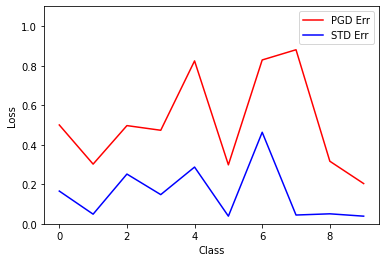

In [ ]:
print('FRL (RW) Adversarially Trained Fashion MNIST Model-- ACCURACY')
show_both_losses_by_class(adv_model_pgd_loss, adv_model_regular_loss, acc=True)